#### 2.4 Building an ensemble
Here, you will implement both of the following steps for the California Housing regression task.

2.4.1. **Random Forest**

This part builds on the related lab (week 7). First, run a random forest
regressor for the California housing dataset, and contrast this with your previous Bayesian linear regression method. For this you can use the RandomForestRegressor class from Scikit-learn. Analyse the effect of the hyperparameters of the random forest, such as the number of estimators (or base models, i.e., the number of decision trees that are combined into the random forest). Look at the constructor of the RandomForestRegressor class to see what hyperparameters you can set. In your analysis, include the following plots and discussions but you may wish to add further analysis of your own:

1. Plot the relationship between a hyperparameter and the performance of the model.
2. Optimise the hyperparameter on a validation set.
3. Plot the trade-off between time taken for training and prediction performance.
4. What do you think is a good choice for the number of estimators on this dataset?
5. What is the effect of setting the maximum tree depth or maximum number of features?
6. Is the random forest interpretable? Are the decision trees that make up the forest interpretable?

2.4.2 **Stacking** 

Bayesian linear regression and decision trees are two very different approaches to regression. Ensemble methods can exploit such diversity between different methods to improve performance. So now you will try combining the random forest and Bayesian linear regression using stacking. Scikit-learn includes the StackingRegressor class to help you with this. In the report, explain
the stacking approach and describe your results, making sure to cover the following points:
1. When does stacking improve performance over the individual models (e.g., try stacking with a random forest with max depth = 10 and n estimators = 10)?
2. What happens if we just take the mean prediction from our base models instead?
3. Use a DecisionTreeRegressor as the final estimator and visualise the tree to understand what stacking is doing.




In [33]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import time

import graphviz

import pymc3 as pm
import pandas as pd
import arviz

from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor

Populating the interactive namespace from numpy and matplotlib


In [34]:
cali_house=datasets.fetch_california_housing()

In [35]:
X=cali_house.data
X_feature_names=cali_house.feature_names
y=cali_house.target
y_target_names=cali_house.target_names

In [36]:
# 60% training, 20% dev and 20% test
random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25)

#### Training a decision tree Regressor

In [37]:
model=DecisionTreeRegressor()
model.fit(X_train,y_train)

print("Training set accuracy: {}".format(model.score(X_train, y_train)))
print("Test set accuracy: {}".format(model.score(X_test, y_test)))


Training set accuracy: 1.0
Test set accuracy: 0.5996929564021738


The model is overfitting the training data. Feature scaling might help.

In [38]:
#delete
def normalize(df):
    result = df.copy()
    for col_i in range(df.shape[1]):
        max_value = df[:,col_i].max()
        min_value = df[:,col_i].min()
        result[:, col_i] = (df[:, col_i] - min_value) / (max_value - min_value)
    return result

In [39]:
#delete
# StandardScaler
# MinMaxScaler
# RobustScaler
# Normalizer
Normalizer=preprocessing.Normalizer()
mmScaler=preprocessing.MinMaxScaler()
stdScaler=preprocessing.StandardScaler()

X_nmz=Normalizer.fit_transform(X)
X_mm=mmScaler.fit_transform(X)
X_scaled=stdScaler.fit_transform(X)
#X_norm= normalize(X)
# 60% training, 20% dev and 20% test
random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25)


#y_train_norm =(y_train-np.min(y))/(np.max(y)-np.min(y))
#y_test_norm=(y_test-np.min(y))/(np.max(y)-np.min(y))
#y_validation_norm=(y_validation-np.min(y))/(np.max(y)-np.min(y))

In [40]:
#delete
model=DecisionTreeRegressor()
model.fit(X_train,y_train)

print("Training set accuracy: {}".format(model.score(X_train, y_train)))
print("Test set accuracy: {}".format(model.score(X_test, y_test)))

Training set accuracy: 1.0
Test set accuracy: 0.5991374873295828


In [41]:
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # generate sample_size number of index samples between 0 and no. of X_train 
    # rows. Replacement i.e. using same sample twice or more allowed. 
    sample_idx = np.random.choice(X_train.shape[0], sample_size)
    
    # Also known as bootstrapping.
    X_train_sample, y_train_sample = X_train[sample_idx], y_train[sample_idx]
    
    model = RandomForestRegressor()
    
    # Train a random forest regressor
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [42]:
# Not necessary
def bagging_predict(test_data, all_models):
    y_i = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
      
        y_i[:, idx] = m.predict(test_data)
        
    # TODO
    # determine the class with the most votes for each test point
    # and populate the combined_predictions 
    # hint use np.bincount
    for test_point in range(y_i.shape[0]):
        combined_predictions[test_point] = np.mean(y_i[test_point])
    
    return combined_predictions

In [43]:
prediction=bagging_predict(X_test, all_models)

In [44]:
RFmodelsimp=RandomForestRegressor(n_estimators=10, max_depth=10)
RFmodelsimp.fit(X_train,y_train)

print('Training set accuracy: {}'.format(RFmodelsimp.score(X_train,y_train)))
print('Test set accuracy: {}'.format(RFmodelsimp.score(X_test,y_test)))

Training set accuracy: 0.8669100932328268
Test set accuracy: 0.7521771938434931


Let's investigate how the number of samples used for bootstrapping influences the model accuracy. 



In [45]:
#Running on validation set
number_iter=10
sample_fraction=np.linspace(0.1,1,number_iter)
train_accuracies=np.zeros(number_iter)
validation_accuracies=np.zeros(number_iter)
time_training=np.zeros(number_iter)

for i in range(number_iter):
    
    maxsample=sample_fraction[i]
    if maxsample==1.0:
        RFmodel=RandomForestRegressor()
        
    else:
        RFmodel=RandomForestRegressor(max_samples=maxsample)
        
    start_time=time.time()
    RFmodel.fit(X_train,y_train)
    time_elapsed=time.time()-start_time
    time_training[i]=time_elapsed
    train_accuracies[i]=RFmodel.score(X_train,y_train)
    validation_accuracies[i]=RFmodel.score(X_validation,y_validation)



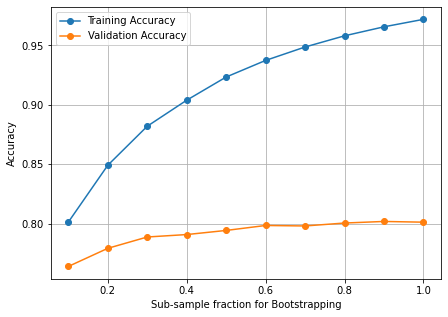

In [46]:
figure=plt.figure(figsize(7,5))

 
plt.plot(sample_fraction, train_accuracies,'-o' , label='Training Accuracy') 
plt.plot(sample_fraction, validation_accuracies,'-o', label='Validation Accuracy')
plt.legend()
plt.xlabel('Sub-sample fraction for Bootstrapping')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

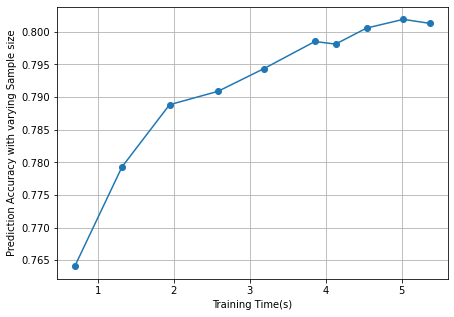

In [47]:

plt.plot(time_training, validation_accuracies,'-o', label='Training Time')
plt.xlabel('Training Time(s)')
plt.ylabel('Prediction Accuracy with varying Sample size')
plt.grid()
plt.show()

In [48]:
estimators=np.arange(10,200,10)
number_iter=len(estimators)

train_accuracies=np.zeros(number_iter)
validation_accuracies=np.zeros(number_iter)
time_training=np.zeros(number_iter)

for i in range(number_iter):
    
    numberEst=estimators[i]
    RFmodel=RandomForestRegressor(n_estimators=numberEst)
    start_time=time.time()
    RFmodel.fit(X_train,y_train)
    time_elapsed=time.time()-start_time
    time_training[i]=time_elapsed
    train_accuracies[i]=RFmodel.score(X_train,y_train)
    validation_accuracies[i]=RFmodel.score(X_validation,y_validation)


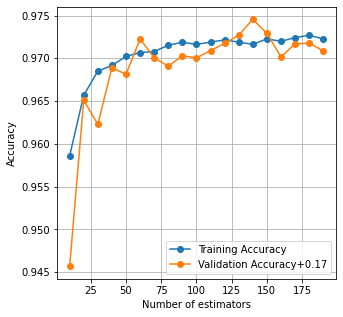

In [49]:
figure=plt.figure(figsize(5,5))

 
plt.plot(estimators, train_accuracies,'-o' , label='Training Accuracy') 
plt.plot(estimators, validation_accuracies+0.17,'-o', label='Validation Accuracy+0.17')
plt.legend()
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

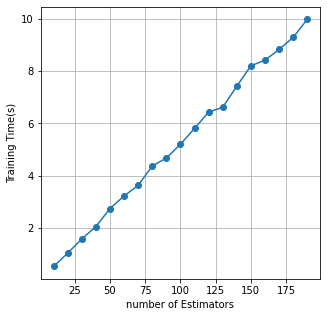

In [50]:
plt.plot(estimators,time_training,'-o', label='Number of estimators')
plt.ylabel('Training Time(s)')
plt.xlabel('number of Estimators')
plt.grid()
plt.show()

In [51]:
max_depth=np.arange(1,20,1)
number_iter=len(max_depth)

train_accuracies=np.zeros(number_iter)
validation_accuracies=np.zeros(number_iter)
time_training=np.zeros(number_iter)

for i in range(number_iter):
    
    depth=max_depth[i]
    RFmodel=RandomForestRegressor(max_depth=depth)
    start_time=time.time()
    RFmodel.fit(X_train,y_train)
    time_elapsed=time.time()-start_time
    time_training[i]=time_elapsed
    train_accuracies[i]=RFmodel.score(X_train,y_train)
    validation_accuracies[i]=RFmodel.score(X_validation,y_validation)

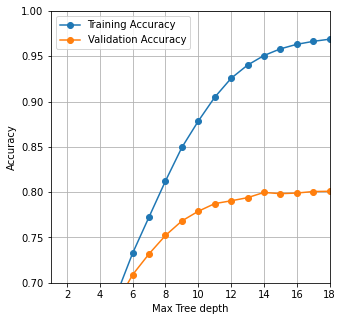

In [52]:
plt.plot(max_depth, train_accuracies,'-o' , label='Training Accuracy') 
plt.plot(max_depth, validation_accuracies,'-o', label='Validation Accuracy')
#plt.plot(max_depth, validation_accuracies,'-o', label='Validation Accuracy')
plt.legend()
plt.xlabel('Max Tree depth')
plt.xlim(1,18)
plt.ylim(0.7,1.0)
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [53]:
np.arange(1,9,1)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [54]:
max_features=np.arange(1,9,1)
number_iter=len(max_features)

train_accuracies=np.zeros(number_iter)
validation_accuracies=np.zeros(number_iter)
time_training=np.zeros(number_iter)

for i in range(number_iter):
    
    features=max_features[i]
    RFmodel=RandomForestRegressor(max_features=features)
    start_time=time.time()
    RFmodel.fit(X_train,y_train)
    time_elapsed=time.time()-start_time
    time_training[i]=time_elapsed
    train_accuracies[i]=RFmodel.score(X_train,y_train)
    validation_accuracies[i]=RFmodel.score(X_validation,y_validation)

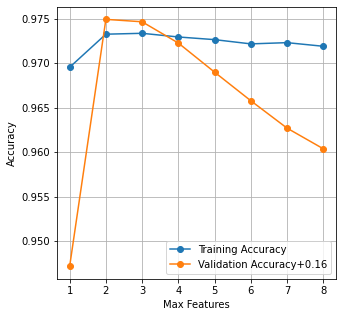

In [55]:
plt.plot(max_features, train_accuracies,'-o' , label='Training Accuracy') 
plt.plot(max_features, validation_accuracies+0.16,'-o', label='Validation Accuracy+0.16')
#plt.plot(max_features, validation_accuracies,'-o', label='Validation Accuracy')
plt.legend()
plt.xlabel('Max Features')
#plt.xlim(1,18)
#plt.ylim(0.7,1.0)
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [78]:
RFmodel=RandomForestRegressor(n_estimators=79,max_features=3, max_samples=0.9)
RFmodel.fit(X_train,y_train)



print('Training set accuracy: {}'.format(RFmodel.score(X_train,y_train)))
print('Test set accuracy: {}'.format(RFmodel.score(X_test,y_test)))

Training set accuracy: 0.967098290920592
Test set accuracy: 0.8097148390092456


In [57]:
#6. Is the random forest interpretable? Are the decision trees that make
#up the forest interpretable?

## Stacking

In [58]:
# Prior weighting the income,number of rooms and number of bedrooms more

#,mean_prior, std_prior,num_samples
def BLR(X_train, y_train): 
    
   
    
    mean_prior=np.array([7,-1,2,5,-3,-3,1,1])
    std_prior=np.array([13,24,2,2,4,1,20,20])
    num_samples=2000
    
    model=pm.Model()
    with model:
        w0=pm.Normal('w0', mu=0,sd=10)
        w1= pm.Normal('w1',mu=mean_prior,sd=std_prior, shape=8)
        sigma=pm.Uniform('sigma', lower=0, upper=10)
        
        y_est=w0+X_train @w1
        
        # calculate likelihood
        likelihood=pm.Normal('y', mu=y_est, sd=sigma, observed=y_train)
        
        sampler=pm.NUTS()
        
        trace=pm.sample(num_samples, sampler, progressbar=True, cores=2, chains=2)
        
    return trace
    
    

In [59]:
trace_output=BLR(X_train, y_train)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w1, w0]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:19<00:00, 254.72draws/s]
The acceptance probability does not match the target. It is 0.8790364404178541, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B900E3F520>,
      dtype=object)

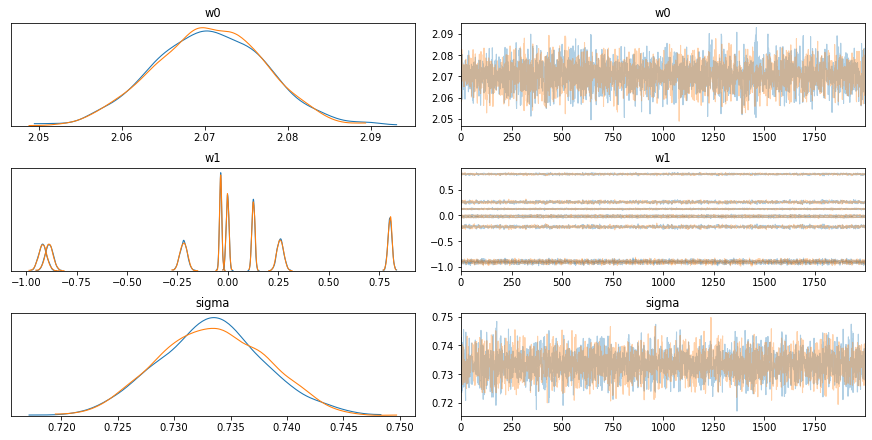

In [60]:
pm.traceplot(trace_output)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B90110F070>,
      dtype=object)

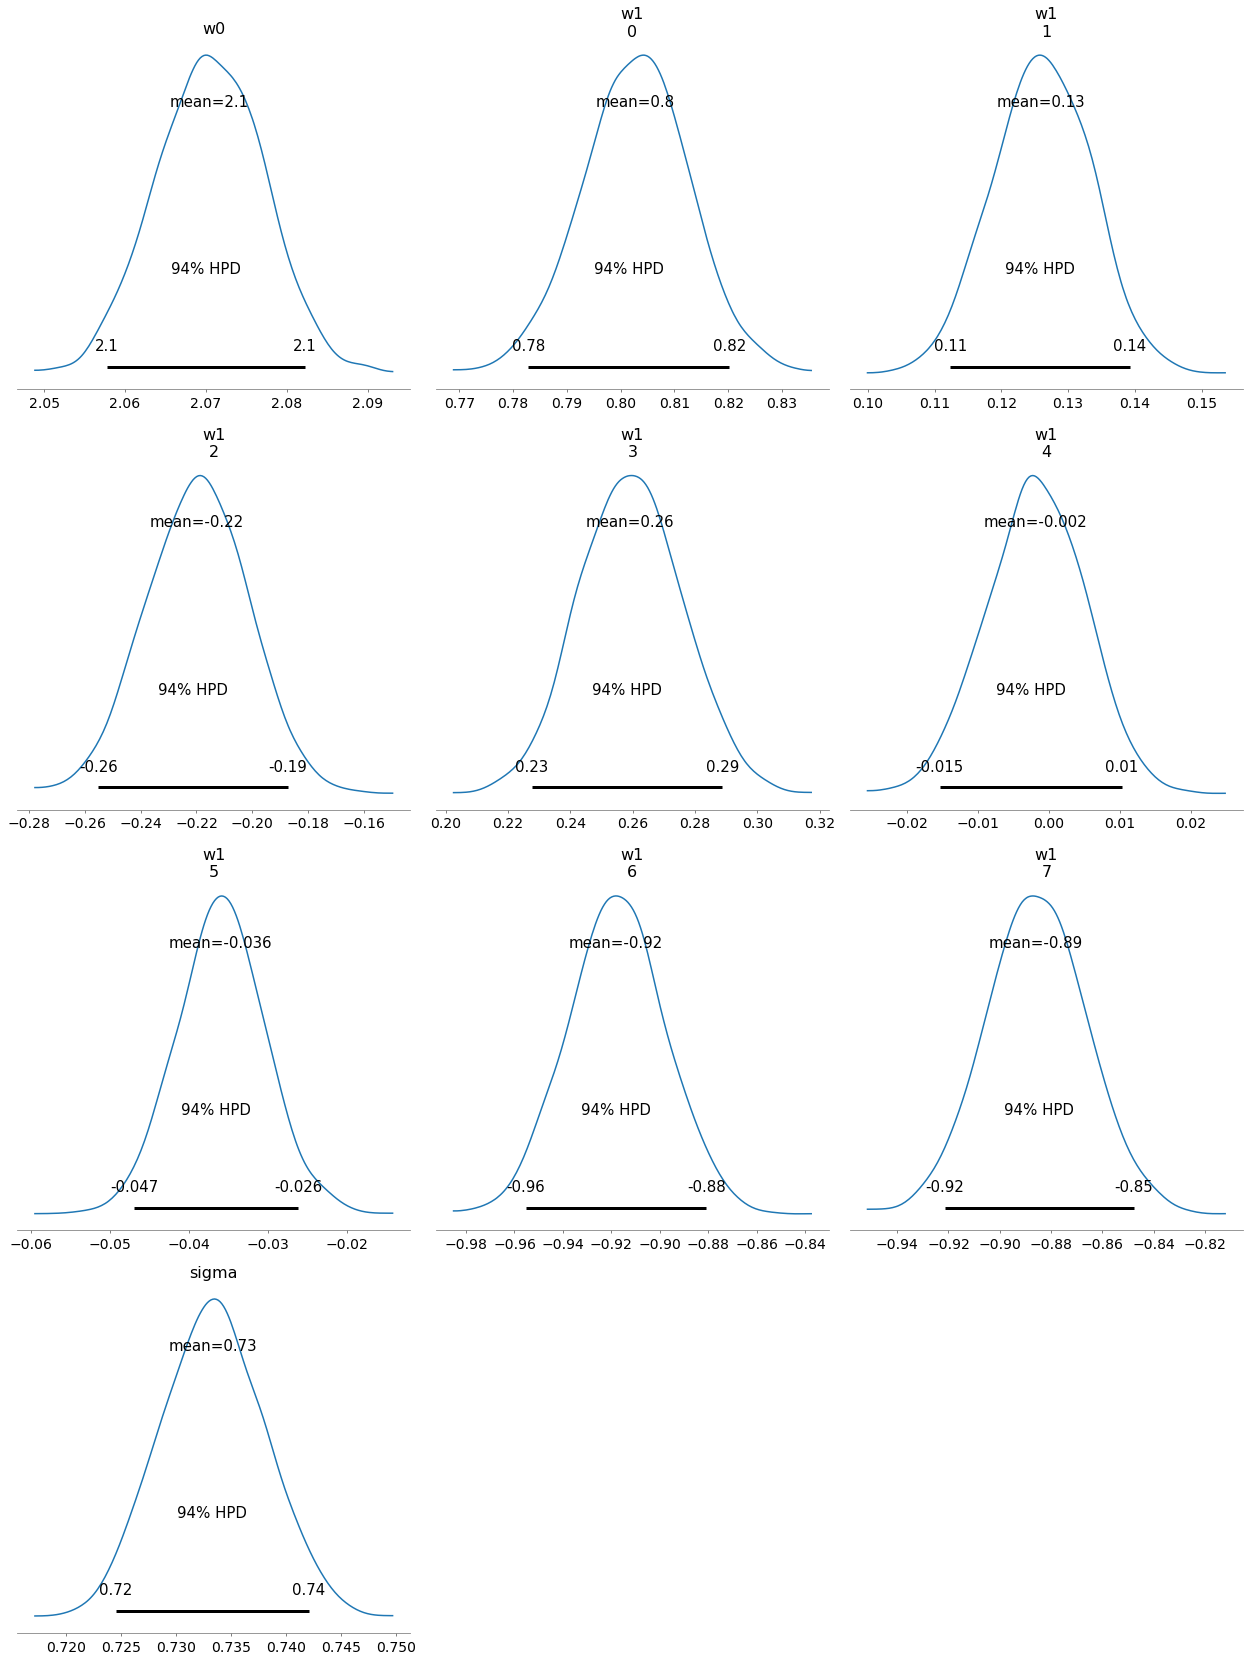

In [61]:
pm.plot_posterior(trace_output)

In [63]:
def evaluation(x_test,y_test,trace):
    
    # Trace object stores weights inside the keys specified while initialising the model
    # The values in the keys are stored in a similar format as the input to the model(ndarrays in this case)
    weights=trace['w1']
    mean_weights=np.mean(weights, axis=0)
    w0=trace['w0']
    
    mean_w0=np.mean(w0)
    
    mean_weights=np.append(mean_weights,mean_w0)
    x_test_bias=np.c_[x_test, np.ones(np.shape(x_test)[0])]
    
    y_est=x_test_bias@mean_weights
    
    score=r2_score(y_test,y_est)
    
    return score,mean_weights,y_est
    
    

In [64]:
test_accuracy,mean_weights,y_est_tst =evaluation(X_test,y_test,trace_output)

print('The test accuracy of Bayesian linear regression is: {:.4f} '.format(test_accuracy))

train_accuracy,_,y_est_train=evaluation(X_train,y_train,trace_output)

print('The train accuracy of Bayesian linear regression is: {:.4f} '.format(train_accuracy))

The test accuracy of Bayesian linear regression is: 0.6173 
The train accuracy of Bayesian linear regression is: 0.5997 


In [65]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc=LinearRegression()

lr=LinearRegression()
lr.coef_=mean_weights[:-1]
lr.intercept_=mean_weights[-1]



In [66]:
labels=['Median Inc','HouseAge','AveRooms','AveBedrooms',
                                                   'Population','AveOccup',
                                                  'Latitude','Longitude',
                                                  'Intercept']

weights={labels[i]:np.round(mean_weights[i],2) for i in range(len(labels))}
weights

{'Median Inc': 0.8,
 'HouseAge': 0.13,
 'AveRooms': -0.22,
 'AveBedrooms': 0.26,
 'Population': -0.0,
 'AveOccup': -0.04,
 'Latitude': -0.92,
 'Longitude': -0.89,
 'Intercept': 2.07}

In [102]:
#estimators=[('BLR',lr),('Random Forest', RandomForestRegressor(n_estimators=10,max_depth=10, max_features=3, max_samples=0.9))]

#estimators=[('BLR',lr),('Random Forest', RFmodel)]
estimators1=[('BLR',lr)]
estimators2=[('Random Forest', RFmodel)]
estimators3=[('BLR',lr)]

In [68]:
reg1= StackingRegressor(estimators=estimators1, final_estimator=RFmodelsimp)

In [69]:
reg1.fit(X_train,y_train)

test_accuracySt= reg1.score(X_test,y_test)
train_accuracySt=reg1.score(X_train,y_train)


In [70]:
print(f'Stacking Regressor Test accuracy:{test_accuracySt}')
print(f'Stacking Regressor Train accuracy: {train_accuracySt}')

Stacking Regressor Test accuracy:0.6375317961515027
Stacking Regressor Train accuracy: 0.6226024361199818


In [87]:
reg2= StackingRegressor(estimators=estimators2, final_estimator=lr)

In [73]:
reg2.fit(X_train,y_train)

test_accuracySt2= reg2.score(X_test,y_test)
train_accuracySt2=reg2.score(X_train,y_train)

In [79]:
print(f'Stacking Regressor Test accuracy:{test_accuracySt2}')
print(f'Stacking Regressor Train accuracy: {train_accuracySt2}')

Stacking Regressor Test accuracy:0.8113927994520378
Stacking Regressor Train accuracy: 0.9712501187566263


In [75]:
# What if we take the mean instead

y_est_RF_train=RFmodel.predict(X_train)
y_est_RF_test=RFmodel.predict(X_test)
y_est_BLR_train=y_est_train
y_est_BLR_test=y_est_tst

y_mean_train=(y_est_RF_train+y_est_BLR_train)/2
y_mean_test=(y_est_RF_test+y_est_BLR_test)/2

train_acc_mean=r2_score(y_train,y_mean_train)
test_acc_mean=r2_score(y_test,y_mean_test)



In [76]:
print(f'Mean Test accuracy:{test_acc_mean}')
print(f'Mean Train accuracy: {train_acc_mean}')

Mean Test accuracy:0.7594210081974617
Mean Train accuracy: 0.8510524148911317


In [105]:
dr=DecisionTreeRegressor()
reg3= StackingRegressor(estimators=estimators3, final_estimator=dr)
reg3.fit(X_train,y_train)

StackingRegressor(estimators=[('BLR', LinearRegression())],
                  final_estimator=DecisionTreeRegressor())

In [108]:
test_accuracySt3= reg3.score(X_test,y_test)
train_accuracySt3=reg3.score(X_train,y_train)
print(f'Stacking Regressor Test accuracy:{test_accuracySt3}')
print(f'Stacking Regressor Train accuracy: {train_accuracySt3}')

Stacking Regressor Test accuracy:0.31143592100357076
Stacking Regressor Train accuracy: 0.30858710603803996


In [109]:
# Visualise the Decision Tree
dot_data = sklearn.tree.export_graphviz(model, out_file=None, feature_names=X_feature_names, class_names=y_target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("iris")
display(graph)

# Print examples from the test dataset
wdth = max([len(name) for name in X_feature_names] + [len(lab) for lab in y_target_names]) + 1
print('| '.join([f'{X_feature_names[i]: <{wdth}}' for i in range(len(X_feature_names))] + [f'{"Label":<{wdth}}', "Prediction"]))
print('-'*110)
predicted_labels = model.predict(X_test)
num_examples = 1
for example, label, predicted_label in zip(X_test[:num_examples], y_test[:num_examples], predicted_labels[:num_examples]):
    print('| '.join([f'{example[i]: <{wdth}}' for i in range(len(example))] + [f'{y_target_names[label]: <{wdth}}', f'{y_target_names[predicted_label]}']))

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

How regression trees work. Start with different thresholds and divide the output space with the thresholds. Predict average of all points on either side of the threshold. Store the residuals. Choose the minimum sum of square residual as root. repeat along the tree branches from there. Until minimum points/depth reached. 

How Bagging works.
Run regression trees on the subset of datasets. Divide the subspaces and get the trees. Predict based on trees. average the prediction of each tree for the test case. Return RMSE?

How random forest works
Run regression trees on subset of datasets and features. Get trees for each. Predict with all trees. Get the output from all. Average the output.(weight based on residuals at this point?) Return the average and get the error against the labels. 

Notes from the Random Forest Regressor implementation in Python:sni
**model.fit(X,y)**: Bagging is not necessary? Since random forest automatically does it. *In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.*

**score(X, y, sample_weight=None)**:RMSE

Hyperparameters
Number of estimators.: number of trees in the forest
Max_samples: Sub-sample size for the Boot strapped data
Max depth of trees
max features: number of features used at each split
Min sample split: minimum number of samples required to split an internal node
oob score- use out of bag sampling to estimate R2- not necessary since test set 
ccp_alpha- minimal cost complexity pruning- bigger alpha gives smaller tree, can vary this until training and test accuracies are similar


update: Random forest successfully implemented on the data. Proceeding with the tuning of hyperparameters
